In [2]:
import sys, os
sys.path.append('/usr/local/lib/python3.7/site-packages')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
import pandas as pd
import numpy as np
import sklearn
import random
import joblib
import matplotlib
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from sklearn.model_selection import learning_curve

In [4]:
# Read preprocessed data

# 5.0    2077511
# 4.0    1254099
# 3.0     639748
# 1.0     628044
# 2.0     456590

# headers = ["business_id", "stars", "text", "date", "positive"]
headers = ["business_id", "stars", "text", "date", "useful", "funny", "cool", "positive"]
# dtype = {"business_id" : str, 
#           "stars" : np.float, 
#           "text" : str, 
#           "date" : str,
#           "positive" : np.float}
dtype = {"business_id" : str, 
         "stars" : np.float, 
         "text" : str, 
         "date" : str,
         "useful" : np.float,
         "funny" : np.float,
         "cool" : np.float,
         "positive" : np.int}
# parse_dates = ['date']

s = 30000
n = 5055992


skiprows = sorted(random.sample(range(1,n+1), n-s))

df = pd.read_csv('data/preprocessed_data4.csv', 
                 header=0, 
                 names=headers, 
                 dtype=dtype, 
                 # parse_dates=parse_dates,
                 skiprows=skiprows,
                 error_bad_lines=False,
                 warn_bad_lines=True)

In [5]:
df.head()
print(df.shape)

(30000, 8)


In [6]:
# Create a bag of words for each review
# train_size = 30000

df = df.dropna()
corpus = df["text"]
# print(corpus.shape)

vectorizer = CountVectorizer()
vector = vectorizer.fit_transform(corpus)
# print(vectorizer.get_feature_names())
# print(vector.toarray())
print (vector.shape)

(30000, 46070)


In [7]:
# Train test split 
X = vector.toarray()
print (X.shape)
print (df["positive"].to_numpy().shape)
features = np.vstack((df["positive"].to_numpy(), df["useful"].to_numpy(), df["funny"].to_numpy(), df["cool"].to_numpy())).T
# features = df["positive"].to_numpy()
# print(features.shape)
# X = np.hstack((X, features[:, None]))
X = np.hstack((X, features))
print(X.shape)
y = df["stars"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(30000, 46070)
(30000,)
(30000, 46074)


In [80]:
# Train Naive Bayes

estimator = MultinomialNB()
param_grid = {"alpha" : [1.0],
              "fit_prior" : True,
              "class_prior" : [456590/n, 628044/n, 639748/n, 1254099/n, 2077511/n]
             }
param_grid = {}
clf = GridSearchCV(estimator=estimator, 
                   param_grid=param_grid,
                   cv=5,
                   verbose=True)
clf.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None, param_grid={},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [81]:
clf.score(X_test, y_test)


0.5995

In [82]:
0.58975 - alpha=0.5, size=30000, no extra
0.586417 - alpha = 1.0, size=40000, no extra
0.57989 - alpha = 1.0, size=30000, extra
0.5837 - alpha = 0.5, size=30000, extra
0.5905 - alpha=0.5, size=30000, extra, 0.2 test_size
0.613166 - alpha = 0.5

SyntaxError: invalid syntax (<ipython-input-82-2bfa8704eb02>, line 1)

In [87]:
param_path ='nb_param.pkl'
model_path ='nb_model.pkl'  
joblib.dump(clf.get_params(), param_path)
joblib.dump(clf, model_path)

['nb_model.pkl']

In [117]:
param_path ='nb_param.pkl'
model_path ='nb_model.pkl' 
param = joblib.load(param_path)
clf = joblib.load(model_path)

In [110]:
one_star_index = clf.best_estimator_.feature_log_prob_[0, :].argsort()[::-1]
two_star_index = clf.best_estimator_.feature_log_prob_[1, :].argsort()[::-1]
three_star_index = clf.best_estimator_.feature_log_prob_[2, :].argsort()[::-1]
four_star_index = clf.best_estimator_.feature_log_prob_[3, :].argsort()[::-1]
five_star_index = clf.best_estimator_.feature_log_prob_[4, :].argsort()[::-1]

one_star_prob = np.sort(np.exp(clf.best_estimator_.feature_log_prob_[0, :]))
two_star_prob = np.sort(np.exp(clf.best_estimator_.feature_log_prob_[1, :]))
three_star_prob = np.sort(np.exp(clf.best_estimator_.feature_log_prob_[2, :]))
four_star_prob = np.sort(np.exp(clf.best_estimator_.feature_log_prob_[3, :]))
five_star_prob = np.sort(np.exp(clf.best_estimator_.feature_log_prob_[4, :]))

one_star_words = np.take(vectorizer.get_feature_names(), one_star_index[:10])
two_star_words = np.take(vectorizer.get_feature_names(), two_star_index[:10])
three_star_words = np.take(vectorizer.get_feature_names(), three_star_index[:10])
four_star_words = np.take(vectorizer.get_feature_names(), four_star_index[:10])
five_star_words = np.take(vectorizer.get_feature_names(), five_star_index[:10])

print("One star: ", one_star_words)
print("Two stars: ", two_star_words)
print("Three stars: ", three_star_words)
print("Four stars: ", four_star_words)
print("Five stars: ", five_star_words)

One star:  ['food' 'place' 'time' 'service' 'order' 'one' 'back' 'like' 'get' 'would']
Two stars:  ['food' 'place' 'good' 'like' 'time' 'service' 'get' 'one' 'ordered'
 'would']
Three stars:  ['food' 'good' 'place' 'like' 'service' 'time' 'would' 'one' 'great'
 'really']
Four stars:  ['good' 'food' 'place' 'great' 'time' 'like' 'service' 'really' 'one'
 'get']
Five stars:  ['food' 'place' 'great' 'good' 'service' 'time' 'best' 'delicious' 'one'
 'back']


In [17]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True,
                       verbose=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

NameError: name 'plot_learning_curve' is not defined

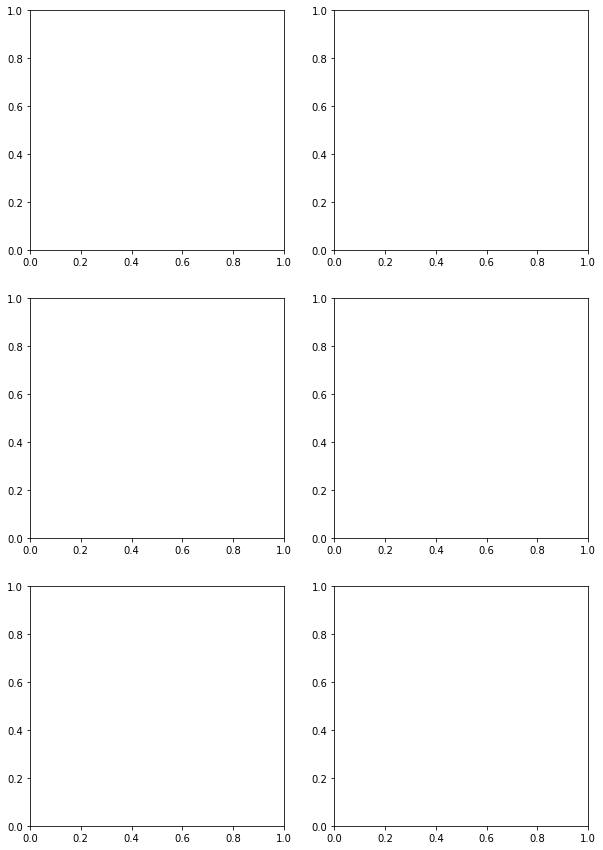

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
title = "Learning Curves (Naive Bayes)"
nb = MultinomialNB(alpha = 0.5, fit_prior=True, class_prior=[456590/n, 628044/n, 639748/n, 1254099/n, 2077511/n])
plot_learning_curve(nb, title, X_train, y_train, axes=axes[:, 0], ylim=(0.7, 1.01),
                     cv=5, n_jobs=1)
plt.show()